# ZTF data: alerts and light curves

---

Run this notebook in the browser in `Google Colab`: 

<a href="https://colab.research.google.com/github/dmitryduev/kowalski/blob/master/nb/ztf.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

<b>Tip:</b> if you are running this notebook in `Google Colab` and run out of disk space with the default runtime, try changing it to a GPU-accelerated one in `Runtime` -> `Change runtime type` -> `Hardware accelerator` -> `GPU`.

---

## ZTF alerts

See [here](https://zwickytransientfacility.github.io/ztf-avro-alert/) for a detailed description of the ZTF alert packet contents.

A dedicated `Kafka` consumer running on the Caltech's `Kowalski` instance listens to the ZTF alert stream. All alerts are saved into the database. To optimize data storage/querying and to remove redundant data, the alert data are dealt with as follows.

- Individual alerts minus the `prv_candidates` block are stored in the `ZTF_alerts` collection. Machine learning models are executed on individual alerts and the results are save to the `classifications` block.

- The contents of the `prv_candidates` blocks of individual alerts are stored in the `ZTF_alerts_aux` collection per `objectId`. No filtering is applied, however all duplicate entries originating from different alerts are removed. [In rare cases, there may be both a detection and a non-detection for the same value of `candidate.jd` due to uncertanties in the astrometry.] The data in `prv_candidates` are stored as a set meaning that they are not ordered. Additionally, the information on cross-matched sources from external catalogs (within $5"$) is saved to the `cross_matches` block.

Let us look at examples.

### Imports and helper functions

In [5]:
from IPython.core.display import display, HTML, JSON

import tqdm
import pandas as pd
import json
from bson.json_util import loads, dumps
import gzip
import os
import io
from typing import Union
import pathlib
import numpy as np
from astropy.io import fits
from astropy.time import Time
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from penquins import Kowalski

In [7]:
array_type = Union[list, tuple, set, np.ndarray]


def is_array(arr):
    if isinstance(arr, list) or isinstance(arr, tuple) or isinstance(arr, set) or isinstance(arr, np.ndarray):
        return True
    else:
        return False

Define a number of helper functions:

In [9]:
def ccd_quad_2_rc(ccd: int, quad: int) -> int:
    # assert ccd in range(1, 17)
    # assert quad in range(1, 5)
    b = (ccd - 1) * 4
    rc = b + quad - 1
    return rc

Convert the compressed FITS cutout images into a numpy array:

In [10]:
def make_triplet(alert, normalize: bool = False):
    """
        Feed in alert packet
    """
    cutout_dict = dict()

    for cutout in ('science', 'template', 'difference'):
        cutout_data = loads(dumps([alert[f'cutout{cutout.capitalize()}']['stampData']]))[0]

        # unzip
        with gzip.open(io.BytesIO(cutout_data), 'rb') as f:
            with fits.open(io.BytesIO(f.read())) as hdu:
                data = hdu[0].data
                # replace nans with zeros
                cutout_dict[cutout] = np.nan_to_num(data)
                # normalize
                if normalize:
                    cutout_dict[cutout] /= np.linalg.norm(cutout_dict[cutout])

        # pad to 63x63 if smaller
        shape = cutout_dict[cutout].shape
        if shape != (63, 63):
            cutout_dict[cutout] = np.pad(cutout_dict[cutout], [(0, 63 - shape[0]), (0, 63 - shape[1])],
                                         mode='constant', constant_values=1e-9)

    triplet = np.zeros((63, 63, 3))
    triplet[:, :, 0] = cutout_dict['science']
    triplet[:, :, 1] = cutout_dict['template']
    triplet[:, :, 2] = cutout_dict['difference']

    return triplet

Plot a cutout image triplet [science, reference, difference]:

In [15]:
def plot_triplet(tr):
    fig = plt.figure(figsize=(8, 2), dpi=120)
    ax1 = fig.add_subplot(131)
    ax1.axis('off')
    ax1.imshow(tr[:, :, 0], origin='upper', cmap=plt.cm.bone, norm=LogNorm())
    ax1.title.set_text('Science')
    ax2 = fig.add_subplot(132)
    ax2.axis('off')
    ax2.imshow(tr[:, :, 1], origin='upper', cmap=plt.cm.bone, norm=LogNorm())
    ax2.title.set_text('Reference')
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    ax3.imshow(tr[:, :, 2], origin='upper', cmap=plt.cm.bone)
    ax3.title.set_text('Difference')
    plt.show()

Simple check if an object has a stellar-like counterpart in the reference image:

In [11]:
def is_star(dflc, match_radius_arcsec=1.5, star_galaxy_threshold=0.4):
    try:
        return (dflc.iloc[-1].distpsnr1 < match_radius_arcsec) & (dflc.iloc[-1].sgscore1 > star_galaxy_threshold)
    except Exception as _e:
        print(_e)
        return False

Assemble objects light curve. The `candidate.magpsf` field present in the alert packets reports the flux in the difference image, and is positive by construction. Alerts however may be from positive or negative subtractions (as identified by the `candidate.isdiffpos` field), and for variable objects the flux in the reference image needs to be included (see p.102 of the [Explanatory Supplement](http://web.ipac.caltech.edu/staff/fmasci/ztf/ztf_pipelines_deliverables.pdf)).

In [12]:
def assemble_lc(dflc, objectId, composite=False, match_radius_arcsec=1.5, star_galaxy_threshold=0.4):
    # mjds:
    dflc['mjd'] = dflc.jd - 2400000.5

    dflc['datetime'] = dflc['mjd'].apply(lambda x: Time(x, format='mjd').datetime)
    
    # strings:
    dflc['dt'] = dflc['datetime'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

    dflc.sort_values(by=['mjd'], inplace=True)

    # fractional days ago
    dflc['days_ago'] = dflc['datetime'].apply(lambda x:
                                              (datetime.datetime.utcnow() - x).total_seconds() / 86400.)

    if is_star(dflc, match_radius_arcsec=match_radius_arcsec, star_galaxy_threshold=star_galaxy_threshold):
        # print('It is a star!')
        # variable object/star? take into account flux in ref images:
        lc = []

        # fix old alerts:
        dflc.replace('None', np.nan, inplace=True)

        # prior to 2018-11-12, non-detections don't have field and rcid in the alert packet,
        # which makes inferring upper limits more difficult
        # fix using pdiffimfilename:
        w = dflc.rcid.isnull()
        if np.sum(w):
            dflc.loc[w, 'rcid'] = dflc.loc[w, 'pdiffimfilename'].apply(lambda x:
                                                      ccd_quad_2_rc(ccd=int(os.path.basename(x).split('_')[4][1:]),
                                                                    quad=int(os.path.basename(x).split('_')[6][1:])))
            dflc.loc[w, 'field'] = dflc.loc[w, 'pdiffimfilename'].apply(lambda x:
                                                                        int(os.path.basename(x).split('_')[2][1:]))

        grp = dflc.groupby(['fid', 'field', 'rcid'])
        impute_magnr = grp['magnr'].agg(lambda x: np.median(x[np.isfinite(x)]))
        impute_sigmagnr = grp['sigmagnr'].agg(lambda x: np.median(x[np.isfinite(x)]))

        for idx, grpi in grp:
            w = np.isnan(grpi['magnr'])
            w2 = grpi[w].index
            dflc.loc[w2, 'magnr'] = impute_magnr[idx]
            dflc.loc[w2, 'sigmagnr'] = impute_sigmagnr[idx]

        # fix weird isdiffpos'es:
        w_1 = dflc['isdiffpos'] == '1'
        dflc.loc[w_1, 'isdiffpos'] = 't'

        dflc['sign'] = 2 * (dflc['isdiffpos'] == 't') - 1
        
        # Eric Bellm 20190722: Convert to DC magnitudes (see p.102 of the Explanatory Supplement)
        dflc['dc_flux'] = 10**(-0.4*dflc['magnr']) + dflc['sign'] * 10**(-0.4*dflc['magpsf'])
        w_dc_flux_good = dflc['dc_flux'] > 0
        dflc.loc[w_dc_flux_good, 'dc_mag'] = -2.5 * np.log10(dflc.loc[w_dc_flux_good, 'dc_flux'])
        dflc.loc[w_dc_flux_good, 'dc_sigmag'] = np.sqrt(
            (10**(-0.4*dflc['magnr'])* dflc['sigmagnr']) **2. + 
            (10**(-0.4*dflc['magpsf']) * dflc['sigmapsf'])**2.) / dflc.loc[w_dc_flux_good, 'dc_flux']
        
        dflc['dc_flux_ulim'] = 10**(-0.4*dflc['magnr']) + 10**(-0.4*dflc['diffmaglim'])
        dflc['dc_flux_llim'] = 10**(-0.4*dflc['magnr']) - 10**(-0.4*dflc['diffmaglim'])
        
        w_dc_flux_ulim_good = dflc['dc_flux_ulim'] > 0
        w_dc_flux_llim_good = dflc['dc_flux_llim'] > 0
        
        dflc.loc[w_dc_flux_ulim_good, 'dc_mag_ulim'] = -2.5 * np.log10(10**(-0.4*dflc.loc[w_dc_flux_ulim_good, 'magnr']) + 
                                                                       10**(-0.4*dflc.loc[w_dc_flux_ulim_good, 'diffmaglim']))
        dflc.loc[w_dc_flux_llim_good, 'dc_mag_llim'] = -2.5 * np.log10(10**(-0.4*dflc.loc[w_dc_flux_llim_good, 'magnr']) - 
                                                                       10**(-0.4*dflc.loc[w_dc_flux_llim_good, 'diffmaglim']))

        # if some of the above produces NaNs for some reason, try fixing it sloppy way:
        for fid in (1, 2, 3):
            if fid in dflc.fid.values:
                ref_flux = None
                w = (dflc.fid == fid) & ~dflc.magpsf.isnull() & (dflc.distnr <= match_radius_arcsec)
                if np.sum(w):
                    ref_mag = np.float64(dflc.loc[w].iloc[0]['magnr'])
                    ref_flux = np.float64(10 ** (0.4 * (27 - ref_mag)))
                    # print(fid, ref_mag, ref_flux)

                wnodet_old = (dflc.fid == fid) & dflc.magpsf.isnull() & \
                             dflc.dc_mag_ulim.isnull() & (dflc.diffmaglim > 0)

                if np.sum(wnodet_old) and (ref_flux is not None):
                    # if we have a non-detection that means that there's no flux +/- 5 sigma from
                    # the ref flux (unless it's a bad subtraction)
                    dflc.loc[wnodet_old, 'difference_fluxlim'] = 10 ** (0.4 * (27 - dflc.loc[wnodet_old, 'diffmaglim']))
                    dflc.loc[wnodet_old, 'dc_flux_ulim'] = ref_flux + dflc.loc[wnodet_old, 'difference_fluxlim']
                    dflc.loc[wnodet_old, 'dc_flux_llim'] = ref_flux - dflc.loc[wnodet_old, 'difference_fluxlim']

                    # mask bad values:
                    w_u_good = (dflc.fid == fid) & dflc.magpsf.isnull() & \
                               dflc.dc_mag_ulim.isnull() & (dflc.diffmaglim > 0) & (dflc.dc_flux_ulim > 0)
                    w_l_good = (dflc.fid == fid) & dflc.magpsf.isnull() & \
                               dflc.dc_mag_ulim.isnull() & (dflc.diffmaglim > 0) & (dflc.dc_flux_llim > 0)

                    dflc.loc[w_u_good, 'dc_mag_ulim'] = 27 - 2.5 * np.log10(dflc.loc[w_u_good, 'dc_flux_ulim'])
                    dflc.loc[w_l_good, 'dc_mag_llim'] = 27 - 2.5 * np.log10(dflc.loc[w_l_good, 'dc_flux_llim'])

        # corrections done, now proceed with assembly
        for fid in (1, 2, 3):
            # print(fid)
            # get detections in this filter:
            w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
            lc_dets = pd.concat([dflc.loc[w, 'jd'], dflc.loc[w, 'dt'], 
                                 dflc.loc[w, 'datetime'], dflc.loc[w, 'days_ago'],
                                 dflc.loc[w, 'mjd'], dflc.loc[w, 'dc_mag'], dflc.loc[w, 'dc_sigmag']],
                                axis=1, ignore_index=True, sort=False) if np.sum(w) else None
            if lc_dets is not None:
                lc_dets.columns = ['jd', 'dt',  'datetime', 'days_ago', 'mjd', 'mag', 'magerr']

            wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
            # print(wnodet)

            lc_non_dets = pd.concat([dflc.loc[wnodet, 'jd'], dflc.loc[wnodet, 'dt'], 
                                     dflc.loc[wnodet, 'datetime'], dflc.loc[wnodet, 'days_ago'],
                                     dflc.loc[wnodet, 'mjd'], dflc.loc[wnodet, 'dc_mag_llim'],
                                     dflc.loc[wnodet, 'dc_mag_ulim']],
                                    axis=1, ignore_index=True, sort=False) if np.sum(wnodet) else None
            if lc_non_dets is not None:
                lc_non_dets.columns = ['jd', 'dt', 'datetime', 'days_ago', 'mjd', 'mag_llim', 'mag_ulim']

            if lc_dets is None and lc_non_dets is None:
                continue

            lc_joint = None

            if lc_dets is not None:
                # print(lc_dets)
                # print(lc_dets.to_dict('records'))
                lc_joint = lc_dets
            if lc_non_dets is not None:
                # print(lc_non_dets.to_dict('records'))
                lc_joint = lc_non_dets if lc_joint is None else pd.concat([lc_joint, lc_non_dets],
                                                                          axis=0, ignore_index=True, sort=False)

            # sort by date and fill NaNs with zeros
            lc_joint.sort_values(by=['mjd'], inplace=True)
            # print(lc_joint)
            lc_joint = lc_joint.fillna(0)

            # single or multiple alert packets used?
            lc_id = f"{objectId}_composite_{datetime.datetime.utcnow().strftime('%Y%m%d_%H%M%S')}" \
                if composite else f"{objectId}_{int(dflc.loc[0, 'candid'])}"
            # print(lc_id)

            lc_save = {"telescope": "PO:1.2m",
                       "instrument": "ZTF",
                       "filter": fid,
                       "source": "alert_stream",
                       "comment": "corrected for flux in reference image",
                       "id": lc_id,
                       "lc_type": "temporal",
                       "data": lc_joint.to_dict('records')
                       }
            lc.append(lc_save)

    else:
        # print('Not a star!')
        # not a star (transient): up to three individual lcs
        lc = []

        for fid in (1, 2, 3):
            # print(fid)
            # get detections in this filter:
            w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
            lc_dets = pd.concat([dflc.loc[w, 'jd'], dflc.loc[w, 'dt'], 
                                 dflc.loc[w, 'datetime'], dflc.loc[w, 'days_ago'],
                                 dflc.loc[w, 'mjd'], dflc.loc[w, 'magpsf'], dflc.loc[w, 'sigmapsf']],
                                axis=1, ignore_index=True, sort=False) if np.sum(w) else None
            if lc_dets is not None:
                lc_dets.columns = ['jd', 'dt', 'datetime', 'days_ago', 'mjd', 'mag', 'magerr']

            wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()

            lc_non_dets = pd.concat([dflc.loc[wnodet, 'jd'], dflc.loc[wnodet, 'dt'], 
                                     dflc.loc[wnodet, 'datetime'], dflc.loc[wnodet, 'days_ago'],
                                     dflc.loc[wnodet, 'mjd'], dflc.loc[wnodet, 'diffmaglim']],
                                    axis=1, ignore_index=True, sort=False) if np.sum(wnodet) else None
            if lc_non_dets is not None:
                lc_non_dets.columns = ['jd', 'dt', 'datetime', 'days_ago', 'mjd', 'mag_ulim']

            if lc_dets is None and lc_non_dets is None:
                continue

            lc_joint = None

            if lc_dets is not None:
                lc_joint = lc_dets
            if lc_non_dets is not None:
                lc_joint = lc_non_dets if lc_joint is None else pd.concat([lc_joint, lc_non_dets],
                                                                          axis=0, ignore_index=True, sort=False)

            # sort by date and fill NaNs with zeros
            lc_joint.sort_values(by=['mjd'], inplace=True)
            lc_joint = lc_joint.fillna(0)

            # single or multiple alert packets used?
            lc_id = f"{objectId}_composite_{datetime.datetime.utcnow().strftime('%Y%m%d_%H%M%S')}" \
                if composite else f"{objectId}_{int(dflc.loc[0, 'candid'])}"

            lc_save = {"telescope": "PO:1.2m",
                       "instrument": "ZTF",
                       "filter": fid,
                       "source": "alert_stream",
                       "comment": "no corrections applied. using raw magpsf, sigmapsf, and diffmaglim",
                       "id": lc_id,
                       "lc_type": "temporal",
                       "data": lc_joint.to_dict('records')
                       }
            lc.append(lc_save)

    return dflc, lc

Plot the light curve(s):

In [40]:
def plot_lc(lcs, dpi=200):
    fig = plt.figure(figsize=(10, 4), dpi=dpi)
    ax = fig.add_subplot(111)
    ax.title.set_text('Light curve')
    
    # 1=g, 2=r, 3=i
    colors = {1: "#28a745", 2: "#dc3545", 3: "#333333"}
    filter_names = {1: "ZTF g", 2: "ZTF r", 3: "ZTF i"}

    for lc in lcs:
        fid = lc['filter']
        df_lc = pd.DataFrame.from_records(lc['data'])
#         display(df_lc)
        # mags:
        if 'mag' in df_lc:
            w = df_lc['mag'] > 1e-6
            if np.sum(w) > 0:
                t = df_lc.loc[w, 'mjd']
                mag = df_lc.loc[w, 'mag']
                mag_error = df_lc.loc[w, 'magerr']
                ax.errorbar(t, mag, yerr=mag_error, elinewidth=0.3, marker='.', c=colors[fid], lw=0, label=f'{filter_names[fid]}')
        
        # upper limits:
        if 'mag_ulim' in df_lc:
            w = df_lc['mag_ulim'] > 1e-6
            if np.sum(w) > 0:
                t = df_lc.loc[w, 'mjd']
                mag_ulim = df_lc.loc[w, 'mag_ulim']
                ax.plot(t, mag_ulim, marker='v', markersize=4, c=colors[fid], alpha=0.3, lw=0, label=f'{filter_names[fid]} upper limit')
        
        # lower limits:
        if 'mag_llim' in df_lc:
            w = df_lc['mag_llim'] > 1e-6
            if np.sum(w) > 0:
                t = df_lc.loc[w, 'mjd']
                mag_llim = df_lc.loc[w, 'mag_llim']
                ax.plot(t, mag_llim, marker='^', markersize=4, c=colors[fid], alpha=0.3, lw=0, label=f'{filter_names[fid]} lower limit')
    
    ax.invert_yaxis()
    ax.grid(True, lw=0.3)
    ax.set_xlabel('MJD')
    ax.set_ylabel('mag')
    # ax.legend(loc='best')
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize='x-small')
    
    plt.show()

Plot the cutouts and the light curves in a compact way:

In [14]:
def plot_triplet_lc(triplet, lcs):
    fig = plt.figure(figsize=(12, 3), dpi=150)
    
    gs = fig.add_gridspec(1, 5)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.axis('off')
    ax1.imshow(tr[:, :, 0], origin='upper', cmap=plt.cm.bone, norm=LogNorm())
    ax1.title.set_text('Science')
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.axis('off')
    ax2.imshow(tr[:, :, 1], origin='upper', cmap=plt.cm.bone, norm=LogNorm())
    ax2.title.set_text('Reference')
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.axis('off')
    ax3.imshow(tr[:, :, 2], origin='upper', cmap=plt.cm.bone)
    ax3.title.set_text('Difference')
    
    ax = fig.add_subplot(gs[0, 3:])
    ax.title.set_text('Light curve')
    
    # 1=g, 2=r, 3=i
    colors = {1: "#28a745", 2: "#dc3545", 3: "#333333"}
    filter_names = {1: "ZTF g", 2: "ZTF r", 3: "ZTF i"}

    for lc in lcs:
        fid = lc['filter']
        df_lc = pd.DataFrame.from_records(lc['data'])
#         display(df_lc)
        # mags:
        if 'mag' in df_lc:
            w = df_lc['mag'] > 1e-6
            if np.sum(w) > 0:
                t = df_lc.loc[w, 'mjd']
                mag = df_lc.loc[w, 'mag']
                mag_error = df_lc.loc[w, 'magerr']
                ax.errorbar(t, mag, yerr=mag_error, elinewidth=0.3, marker='.', c=colors[fid], lw=0, label=filter_names[fid])
        
        # upper limits:
        if 'mag_ulim' in df_lc:
            w = df_lc['mag_ulim'] > 1e-6
            if np.sum(w) > 0:
                t = df_lc.loc[w, 'mjd']
                mag_ulim = df_lc.loc[w, 'mag_ulim']
                ax.plot(t, mag_ulim, marker='v', markersize=5, c=colors[fid], alpha=0.3, lw=0, label=f'{filter_names[fid]} upper limit')
        
        # lower limits:
        if 'mag_llim' in df_lc:
            w = df_lc['mag_llim'] > 1e-6
            if np.sum(w) > 0:
                t = df_lc.loc[w, 'mjd']
                mag_llim = df_lc.loc[w, 'mag_llim']
                ax.plot(t, mag_llim, marker='^', markersize=5, c=colors[fid], alpha=0.3, lw=0, label=f'{filter_names[fid]} lower limit')
    
    ax.invert_yaxis()
    ax.grid(True, lw=0.3)
    ax.set_xlabel('MJD')
    ax.set_ylabel('mag')
    ax.legend(loc='best', fontsize='x-small')
    
    plt.tight_layout()
    plt.show()

### Connect to Kowalski and run a few queries

In [6]:
# with open('secrets_penquins.json', 'r') as f:
#     secrets = json.load(f)

# k = Kowalski(username=secrets['kowalski']['username'], password=secrets['kowalski']['password'])

k = Kowalski(host='localhost', port=8000, protocol='http', username='admin', password='admin')

connection_ok = k.check_connection()
print(f'Connection OK: {connection_ok}')

Connection OK: True


Fetch an alert and display its contents and the cutouts:

In [44]:
q = {"query_type": "find",
     "query": {
         "catalog": "ZTF_alerts",
         "filter": {"candid": 905172675915015031},
#          "filter": {"objectId": "ZTF18acrkaks"},
         "projection": {"_id": 0},
     }
     }
r = k.query(query=q)
alert = r['result_data']['query_result'][0]
display(JSON(alert, expanded=False))

<IPython.core.display.JSON object>

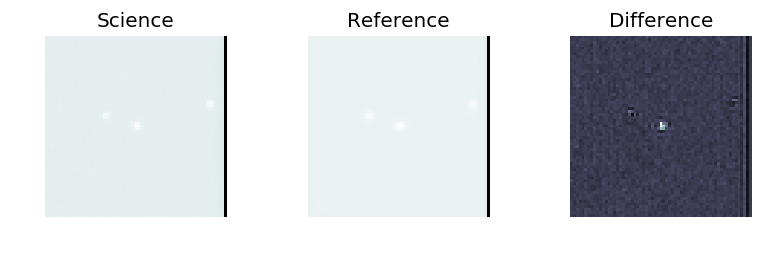

In [23]:
tr = make_triplet(alert)
plot_triplet(tr)

Let us now assemble and plot the light curve for this source.

First get the detections that were sent out as alerts:

In [30]:
q = {"query_type": "find",
     "query": {
         "catalog": "ZTF_alerts",
         "filter": {"objectId": alert['objectId']},
         "projection": {"_id": 0, "cutoutScience": 0, "cutoutTemplate": 0, "cutoutDifference": 0},
     }
     }
r = k.query(query=q)
alerts = r['result_data']['query_result']
print(f'Number of alerts for {alert["objectId"]}:', len(alerts))

Number of alerts for ZTF17aabxjix: 1


In [27]:
dfs = []

for packet in alerts:
    df = pd.DataFrame(packet['candidate'], index=[0])
    dfs.append(df)

# drop duplicate entries. decide using jd
dfs = pd.concat(dfs, ignore_index=True, sort=False).drop_duplicates(subset='jd').reset_index(drop=True)

display(dfs)

,jd,fid,pid,diffmaglim,pdiffimfilename,programpi,programid,candid,isdiffpos,tblid,...,zpmed,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,drb,drbversion
0,2.458660e+06,3,905172675915,19.636391,ztf_20190625172674_000580_zi_c15_o_q4_scimrefd...,Kulkarni,2,905172675915015031,t,31,...,25.560501,0.238,0.297923,0.060151,-999.0,15.953059,-999.0,30.0,0.999402,d6_m7


Now get the `prv_candidates` and merge with `dfs`:

In [31]:
q = {"query_type": "find_one",
     "query": {
         "catalog": "ZTF_alerts_aux",
         "filter": {"_id": alert['objectId']},
         "projection": {"_id": 0},
     }
     }
r = k.query(query=q)
alert_aux = r['result_data']['query_result']
display(JSON(alert_aux, expanded=False))

<IPython.core.display.JSON object>

In [32]:
# concat alert_aux with dfs
df_prv = pd.DataFrame(alert_aux['prv_candidates'])
dflc = pd.concat([dfs, df_prv],
                 ignore_index=True,
                 sort=False).drop_duplicates(subset='jd').reset_index(drop=True).sort_values(by=['jd'])
display(dflc)

/Users/dmitryduev/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dmitryduev/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


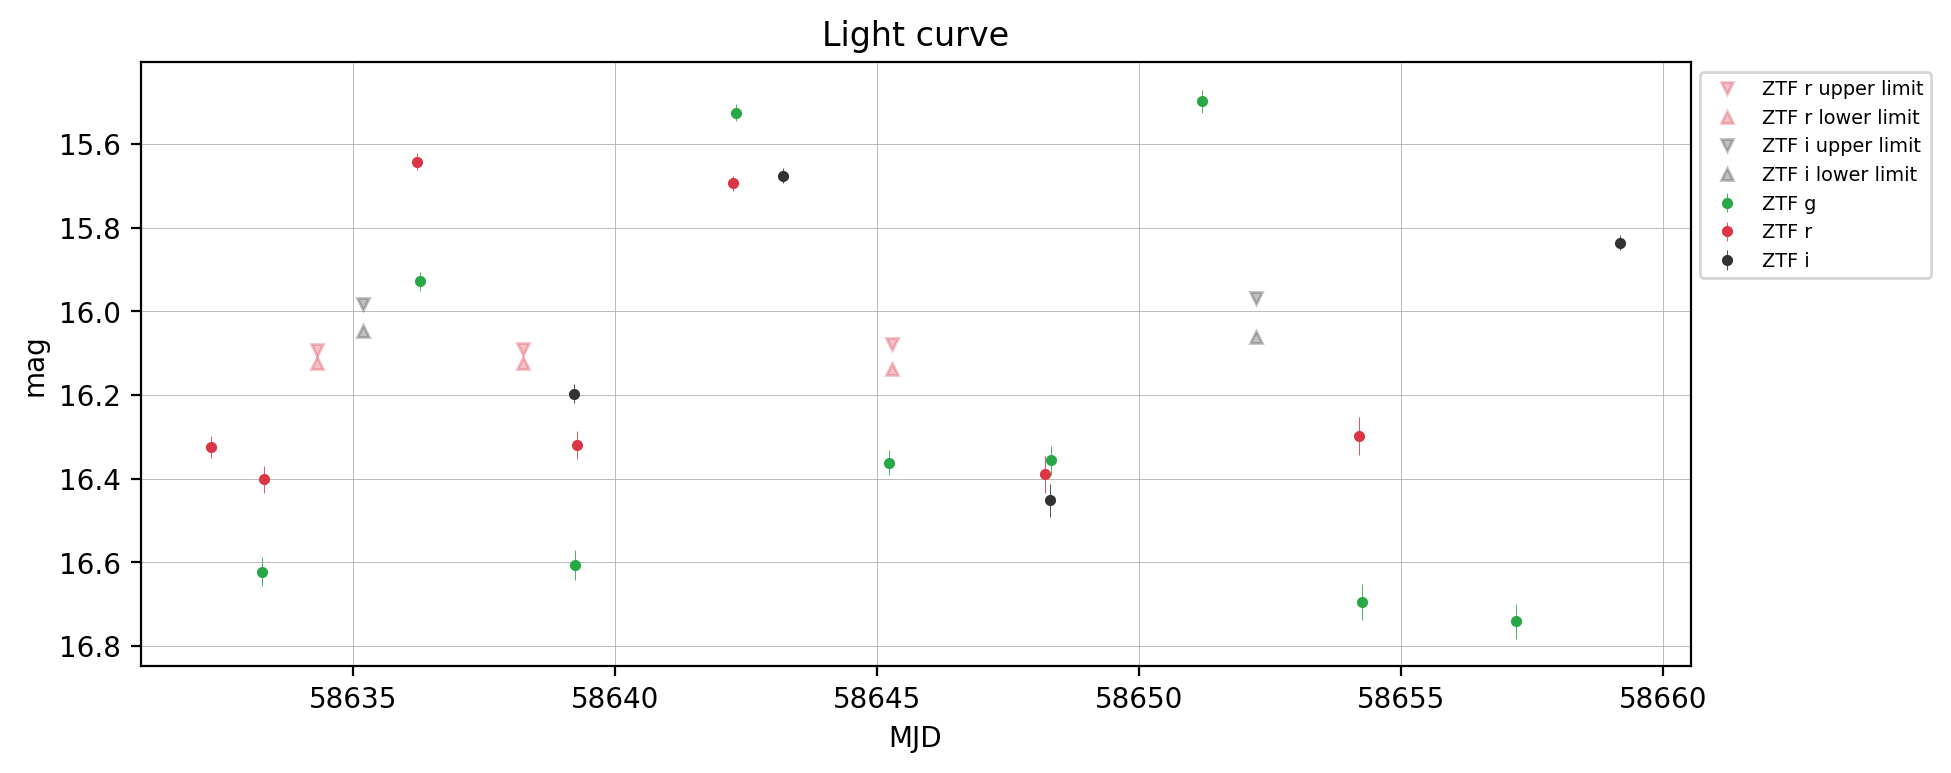

In [41]:
_, lc = assemble_lc(dflc, alert['objectId'], composite=True, 
                    match_radius_arcsec=1.5, star_galaxy_threshold=0.4)

plot_lc(lc)